In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2025-06-04 17:53:23.174485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749059603.377004      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749059603.433605      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Path to the TFRecord files
MONET_TFREC_PATH = "/kaggle/input/gan-getting-started/monet_tfrec"
PHOTO_TFREC_PATH = "/kaggle/input/gan-getting-started/photo_tfrec"

# TFRecord image size
IMG_SIZE = [256, 256]

In [3]:

# Function to parse the TFRecord files
def decode_image(example):
    image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, image_feature_description)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load TFRecords from the folder
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # Skip order for faster loading
    dataset = tf.data.TFRecordDataset(filenames)  # Load TFRecord files
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


I0000 00:00:1749059617.858064      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


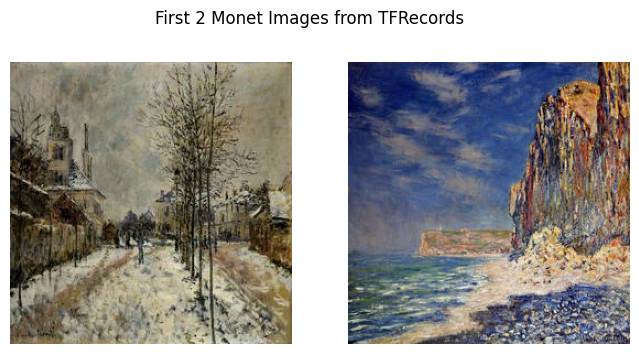

In [4]:
# Get TFRecord filenames
import os
monet_files = tf.io.gfile.glob(os.path.join(MONET_TFREC_PATH, '*.tfrec'))

# Load dataset
monet_ds = load_dataset(monet_files)

# Display the first 2 images
plt.figure(figsize=(8, 4))
for i, image in enumerate(monet_ds.take(2)):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.suptitle("First 2 Monet Images from TFRecords")
plt.show()


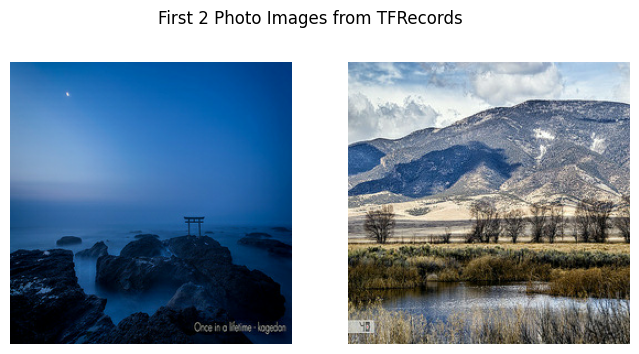

In [5]:
# Get TFRecord filenames
import os
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, '*.tfrec'))

# Load dataset
photo_ds = load_dataset(photo_files)

# Display the first 2 images
plt.figure(figsize=(8, 4))
for i, image in enumerate(photo_ds.take(2)):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.suptitle("First 2 Photo Images from TFRecords")
plt.show()

# Training 

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = [256, 256]
BATCH_SIZE = 1
EPOCHS = 10
STEPS_PER_EPOCH = 300  # Limit to Monet set size

In [7]:
# --- Load and preprocess TFRecords ---
def decode_image(example):
    features = {"image": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Scale to [-1, 1]
    return image

def load_dataset(filenames):
    return (
        tf.data.TFRecordDataset(filenames)
        .map(decode_image, num_parallel_calls=AUTOTUNE)
    )

In [8]:
# --- Load datasets ---
monet_files = tf.io.gfile.glob("/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec")
photo_files = tf.io.gfile.glob("/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec")

monet_ds = load_dataset(monet_files).repeat().shuffle(300).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(photo_files).shuffle(7028).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = tf.data.Dataset.zip((photo_ds, monet_ds)).take(STEPS_PER_EPOCH)


In [9]:
# --- Build CycleGAN models ---
def resnet_generator(name=None):
    inputs = layers.Input(shape=(256, 256, 3))
    
    def residual_block(x):
        y = layers.Conv2D(256, 3, padding='same')(x)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(256, 3, padding='same')(y)
        y = layers.BatchNormalization()(y)
        return layers.add([x, y])
    
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    
    for _ in range(9):
        x = residual_block(x)
    
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    
    return tf.keras.Model(inputs, x, name=name)

def patchgan_discriminator(name=None):
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1, 4, padding='same')(x)
    return tf.keras.Model(inputs, x, name=name)

G = resnet_generator("Photo2Monet")
F = resnet_generator("Monet2Photo")
D_M = patchgan_discriminator("Discriminator_Monet")
D_P = patchgan_discriminator("Discriminator_Photo")


In [10]:
# --- Loss functions and optimizers ---
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * 10.0

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * 5.0

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [11]:
# --- Training step ---
@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = G(real_photo, training=True)
        cycled_photo = F(fake_monet, training=True)

        fake_photo = F(real_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        same_monet = G(real_monet, training=True)
        same_photo = F(real_photo, training=True)

        disc_real_monet = D_M(real_monet, training=True)
        disc_fake_monet = D_M(fake_monet, training=True)

        disc_real_photo = D_P(real_photo, training=True)
        disc_fake_photo = D_P(fake_photo, training=True)

        gen_g_loss = generator_loss(disc_fake_monet)
        gen_f_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = cycle_loss(real_photo, cycled_photo) + cycle_loss(real_monet, cycled_monet)
        id_loss = identity_loss(real_monet, same_monet) + identity_loss(real_photo, same_photo)

        total_gen_g = gen_g_loss + total_cycle_loss + id_loss
        total_gen_f = gen_f_loss + total_cycle_loss + id_loss

        disc_m_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_p_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    g_grad = tape.gradient(total_gen_g, G.trainable_variables)
    f_grad = tape.gradient(total_gen_f, F.trainable_variables)
    d_m_grad = tape.gradient(disc_m_loss, D_M.trainable_variables)
    d_p_grad = tape.gradient(disc_p_loss, D_P.trainable_variables)

    g_optimizer.apply_gradients(zip(g_grad, G.trainable_variables))
    f_optimizer.apply_gradients(zip(f_grad, F.trainable_variables))
    d_m_optimizer.apply_gradients(zip(d_m_grad, D_M.trainable_variables))
    d_p_optimizer.apply_gradients(zip(d_p_grad, D_P.trainable_variables))



Epoch 1/10


  0%|          | 0/300 [00:00<?, ?it/s]

I0000 00:00:1749059693.869959      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


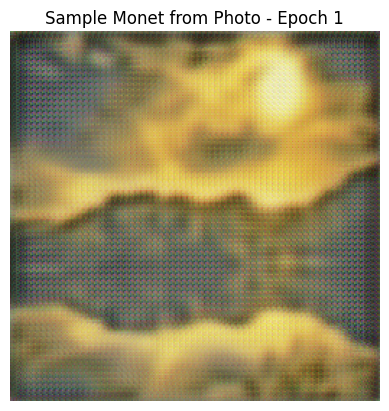

Epoch 2/10


  0%|          | 0/300 [00:00<?, ?it/s]

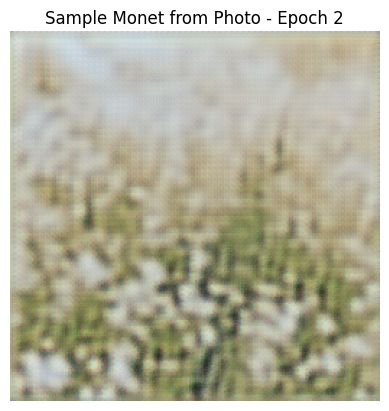

Epoch 3/10


  0%|          | 0/300 [00:00<?, ?it/s]

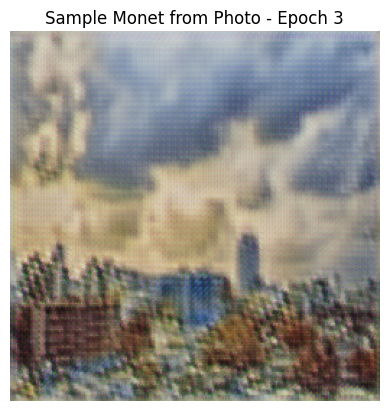

Epoch 4/10


  0%|          | 0/300 [00:00<?, ?it/s]

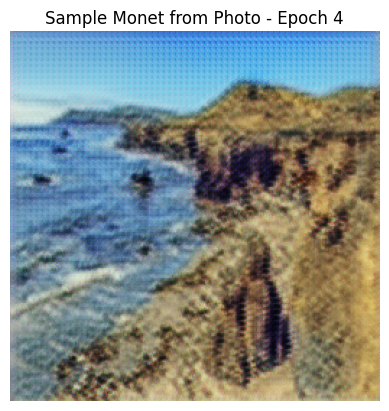

Epoch 5/10


  0%|          | 0/300 [00:00<?, ?it/s]

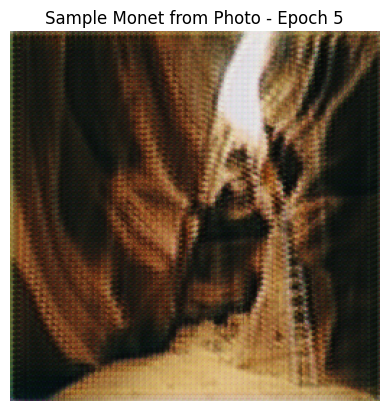

Epoch 6/10


  0%|          | 0/300 [00:00<?, ?it/s]

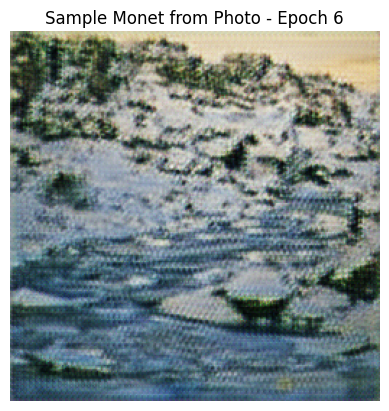

Epoch 7/10


  0%|          | 0/300 [00:00<?, ?it/s]

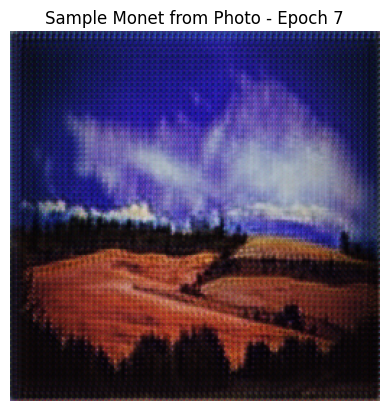

Epoch 8/10


  0%|          | 0/300 [00:00<?, ?it/s]

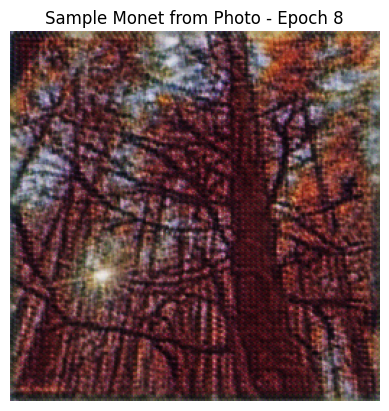

Epoch 9/10


  0%|          | 0/300 [00:00<?, ?it/s]

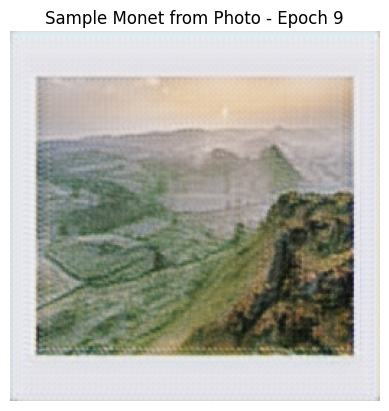

Epoch 10/10


  0%|          | 0/300 [00:00<?, ?it/s]

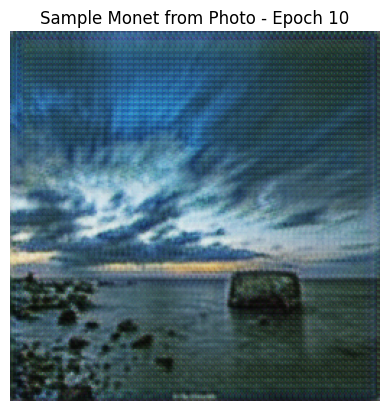

In [12]:
# --- Training loop ---
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for real_photo, real_monet in tqdm(train_ds, total=STEPS_PER_EPOCH):
        train_step(real_photo, real_monet)

    # Save a sample output
    sample_photo = next(iter(photo_ds))
    generated_monet = G(sample_photo, training=False)[0]
    generated_monet = (generated_monet + 1) / 2  # [-1,1] → [0,1]
    plt.imshow(generated_monet)
    plt.title(f"Sample Monet from Photo - Epoch {epoch+1}")
    plt.axis("off")
    plt.show()

In [13]:
G.save('/kaggle/working/monet_generator.keras')